# Set up

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../src/'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Volumes/GoogleDrive/My Drive/USC/Projects/210913-FiberNET/211025-Exp3-ConvVAE/src


In [2]:
import glob
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import dipy
from dipy.viz import window, actor

from data.SubjData import *
from data.data_util import *
from utils.general_util import *
from model.model import *
from inference import *
from evaluation import *

In [3]:
SEED = 2022
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2022 has been set.
GPU is not enabled in this notebook.


In [4]:
model_folder = "../results/models/"
plot_folder = "../results/plots/"
result_data_folder = "../results/data/"
log_folder = "../results/logs/"
data_files_folder = "../data_files/"

# change these if running locally
data_folder = "../../211105-DATA_ADNI3_DWI/"

# Inference

This portion is using a metadata file to get CN/MCI/AD subjects for inference. Ignore if not applicable

In [5]:
df_meta = pd.read_csv(data_files_folder + "metadata.csv")

In [6]:
def select_subject(df, dx='CN', n_subj=5, 
                   subj_train='007_S_6120_20171117_A3_DWI_S127',
                   data_folder='.'):
    set_seed(SEED)
    df_selected = df[(df.DX==dx) & (df.Subject != subj_train)]
    
    if n_subj:
        idx = np.random.choice(len(df_dx), n_subj, replace=False)
        df_selected = df_dx.iloc[idx]
    print(f"Selected {len(df_selected)} {dx} subject.")
    
    return df_selected


In [7]:
subj_cn = select_subject(df_meta, 'CN', None, data_folder=data_folder)
subj_mci = select_subject(df_meta, 'MCI', None, data_folder=data_folder)
subj_ad = select_subject(df_meta, 'Dementia', None, data_folder=data_folder)
print(subj_cn.shape, subj_mci.shape, subj_ad.shape)

Random seed 2022 has been set.
Selected 86 CN subject.
Random seed 2022 has been set.
Selected 44 MCI subject.
Random seed 2022 has been set.
Selected 10 Dementia subject.
(86, 16) (44, 16) (10, 16)


## Run inference script

In [7]:
subj_train = '007_S_6120_20171117_A3_DWI_S127'
model_setting = 'TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00' 
epoch = 4
model_subfolder = f"{model_setting}_{subj_train}"
print(model_subfolder)

TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127


In [10]:
subj='002_S_0413_20190827_A3_DWI_S127'
!python ../src/inference.py --model_name {model_subfolder} \
                        --epoch {epoch} \
                        --seed {SEED} \
                        --subj {subj} \
                        --device {DEVICE} \
                        --data_folder {data_folder} \
                        --model_folder {model_folder} \
                        --result_data_folder {result_data_folder}

Random seed 2021 has been set.
Loaded 002_S_0413_20190827_A3_DWI_S127 with 28 tracts and 19127 lines.
Starting inference...
Saving result to ../results/data/TESTconvVAE3L_XUXU_Z2_B128_LR2E-04_WD1E-03_GCN2E+00_007_S_6120_20171117_A3_DWI_S127/E4_002_S_0413_20190827_A3_DWI_S127


We could also apply inference to multiple subjects like below. But we recommend calling the `_apply_inference` function in the `inference.py` files. As the approach below requires loading the model multiple times.

In [9]:
# Check if inferenced was done on subject if so ignore in the following steps
subj_inferred = []
for f in glob.glob(f"{result_data_folder}{model_subfolder}/*"):
    if f.split("/")[-1].startswith("E"):
        subj_inferred.append(f.split("/")[-1].split("_",1)[1].split(".")[0])
len(subj_inferred)

0

In [ ]:
# Uncomment below to run inference on multiple subjects
# for subj in subj_cn.Subject:
#     if subj in subj_inferred:
#         continue
#     !python ../src/inference.py --model_name {model_subfolder} \
#                             --epoch {epoch} \
#                             --seed {SEED} \
#                             --subj {subj} \
#                             --device {DEVICE} \
#                             --data_folder {data_folder} \
#                             --model_folder {model_folder} \
#                             --result_data_folder {result_data_folder}

## Load Inference

In [5]:
def load_inference(subj_name, model_subfolder, epoch, seed=0, data_folder='.'):
    
    data_args = {'n_points' : 256, 'n_lines' : None, 'min_lines' : 2, 
                'tracts_exclude' : ['CST_L_s', 'CST_R_s'], 'preprocess' : '3d', 
                'rng' : np.random.RandomState(seed), 'verbose': False, 
                'data_folder' : data_folder}

    subj = SubjData(subj_name, **data_args)
    
    result = load_pickle(f"{result_data_folder}{model_subfolder}/E{epoch}_{subj_name}")
    subj.X_encoded = result['X_encoded']
    subj.X_recon = result['X_recon']
    if 'X_encoded_tsne' in result:
        subj.X_encoded_tsne = result['X_encoded_tsne']
    return subj

In [8]:
name='002_S_0413_20190827_A3_DWI_S127'
subj = load_inference(name, model_subfolder, epoch, 
                      seed=SEED, data_folder=data_folder)

Loaded 002_S_0413_20190827_A3_DWI_S127 with 28 tracts and 19127 lines.


# Evaluation

## Plot 2D Embeddings

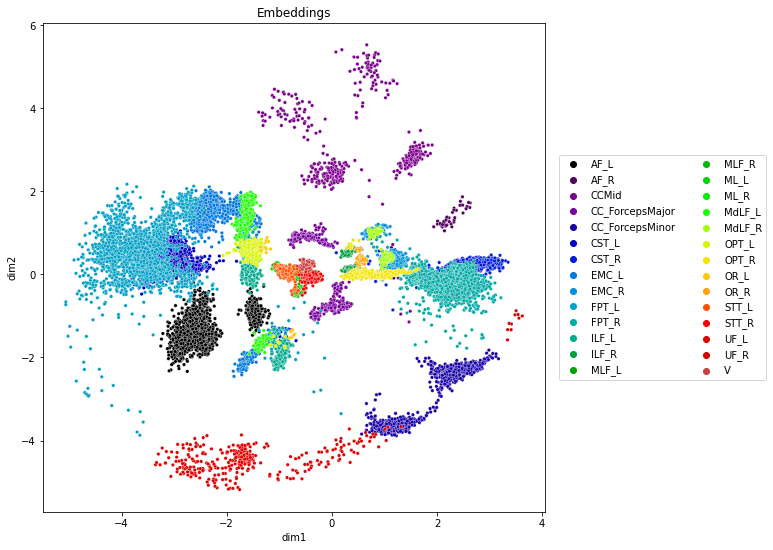

In [10]:
cmap = make_color_map('nipy_spectral', 
                      subj.bundle_idx.keys(),
                      plot_cmap=False)
plot_embedding(subj, cmap)

## Visualze Streamline Recontruction

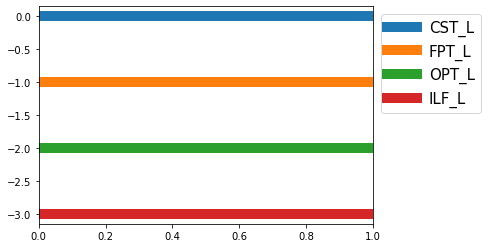

In [12]:
label='ad'
bundles_vis = ['CST_L','FPT_L','OPT_L','ILF_L']
color_list = mpl.cm.datad['tab10']['listed']

for i, name in enumerate(bundles_vis):
    plt.axhline(-i, linewidth=10, c=color_list[i], label=name)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,prop={'size': 15})

In [16]:
'''visualize original streamlines'''
scene = window.Scene()
scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

for i, bundle in enumerate(bundles_vis):
    lines = subj.X[subj.get_bundle_idx(bundle)]
    scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

window.show(scene, size=(1000,1000), reset_camera=False)

In [18]:
'''visualize reconstructed streamlines'''
scene = window.Scene()
scene.set_camera(position=(-433.12, 20.27, -85.26), 
                 focal_point=(-14.58, -19.16, 4.18),
                 view_up=(-0.13, 0.52, 0.84))

for i, bundle in enumerate(bundles_vis):
    lines = subj.X_recon[subj.get_bundle_idx(bundle)]
    scene.add(actor.streamtube(lines, linewidth=0.1, colors=color_list[i]))

window.show(scene, size=(1000,1000), reset_camera=False)